In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ls.config.loader import load_config
import pandas as pd
import os
import numpy as np

### Load configuration file

In [3]:
cfg = load_config("../configs/config.yaml")

In [4]:
df = pd.read_csv(os.path.join(cfg.dataset.data_folder, "icbhi_metadata.csv"))

### Create columns for 4-class and 2-class problems and cycle duraitons

In [5]:
df['label_4c'] = df.apply(lambda r: 
    'Crackle' if r.Crackles==1 and r.Wheezes==0 else
    'Wheeze'  if r.Crackles==0 and r.Wheezes==1 else
    'Both'    if r.Crackles==1 and r.Wheezes==1 else
    'Normal', axis=1)

In [6]:
df["label_2c"] = np.where((df["Crackles"] + df["Wheezes"]) > 0, "Abnormal", "Normal")
df['CycleDur'] = df['CycleEnd'] - df['CycleStart']

df.head()

,PID,Filename,CycleIndex,CycleStart,CycleEnd,Crackles,Wheezes,Split,Device,Fold,Age,Sex,BMI,CW,CH,Disease,AuscLoc,label_4c,label_2c,CycleDur
0,101,101_1b1_Al_sc_Meditron,0,0.036,0.579,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,0.543
1,101,101_1b1_Al_sc_Meditron,1,0.579,2.450,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,1.871
2,101,101_1b1_Al_sc_Meditron,2,2.450,3.893,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,1.443
3,101,101_1b1_Al_sc_Meditron,3,3.893,5.793,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,1.900
4,101,101_1b1_Al_sc_Meditron,4,5.793,7.521,0,0,test,Meditron,1,3.0,F,NaN,19.0,99.0,URTI,Al,Normal,Normal,1.728


### Check for patient leakage/overlap between train and test sets

In [7]:
# Basic integrity checks
assert df["PID"].nunique() == df.groupby("PID")["Split"].nunique().max(), "A PID appears in both splits!"

AssertionError: A PID appears in both splits!

In [8]:
dup_pids = (
    df.groupby("PID")["Split"]
      .nunique()
      .reset_index()
      .query("Split > 1")
)

if not dup_pids.empty:
    print("Patients appearing in both training and test splits:")
    display(df[df["PID"].isin(dup_pids["PID"])][["PID","Filename", "Split"]].drop_duplicates())

Patients appearing in both training and test splits:


,PID,Filename,Split
2896,156,156_2b3_Al_mc_AKGC417L,test
2902,156,156_2b3_Ar_mc_AKGC417L,train
2908,156,156_2b3_Ll_mc_AKGC417L,train
2914,156,156_2b3_Lr_mc_AKGC417L,test
2920,156,156_2b3_Pl_mc_AKGC417L,test
2926,156,156_2b3_Pr_mc_AKGC417L,train
2932,156,156_5b3_Al_mc_AKGC417L,train
2941,156,156_5b3_Ar_mc_AKGC417L,test
2950,156,156_5b3_Ll_mc_AKGC417L,test
2959,156,156_5b3_Lr_mc_AKGC417L,train


In [9]:
assert (df["CycleDur"] > 0).all(), "Non-positive cycle duration found"

### Metadata Dataset Exploitation and Descriptive Statistics

In [10]:
def print_section(title, df):
    print("\n" + "="*80)
    print(f"{title.upper()}")
    print("="*80)
    print(df.to_string())
    print()

## Class imbalances Calculation or the official fixed train/test split (2-class & 4-class problem)

### Global Dataset (Train + Test)

In [11]:
print_section("4-Class Global Counts", df["label_4c"].value_counts().to_frame("count"))
print_section("4-Class Global Proportions", df["label_4c"].value_counts(normalize=True).round(3).to_frame("proportion"))

print_section("2-Class Global Counts", df["label_2c"].value_counts().to_frame("count"))
print_section("2-Class Global Proportions", df["label_2c"].value_counts(normalize=True).round(3).to_frame("proportion"))


4-CLASS GLOBAL COUNTS
          count
label_4c       
Normal     3642
Crackle    1864
Wheeze      886
Both        506


4-CLASS GLOBAL PROPORTIONS
          proportion
label_4c            
Normal         0.528
Crackle        0.270
Wheeze         0.128
Both           0.073


2-CLASS GLOBAL COUNTS
          count
label_2c       
Normal     3642
Abnormal   3256


2-CLASS GLOBAL PROPORTIONS
          proportion
label_2c            
Normal         0.528
Abnormal       0.472



### Class imbalances for each split (4-class problem)

In [12]:
# By split
by_split_4c = df.pivot_table(index="Split", columns="label_4c", values="Filename", aggfunc="count").fillna(0).astype(int)
by_split_prop_4c = by_split_4c.div(by_split_4c.sum(axis=1), axis=0).round(3)
print_section("4-Class Counts by Split", by_split_4c)
print_section("4-Class Proportions by Split", by_split_prop_4c)
# print("\n4c counts by Split:\n", by_split)
# print("\n4c proportions by Split:\n", by_split_prop)


4-CLASS COUNTS BY SPLIT
label_4c  Both  Crackle  Normal  Wheeze
Split                                  
test       143      649    1579     385
train      363     1215    2063     501


4-CLASS PROPORTIONS BY SPLIT
label_4c   Both  Crackle  Normal  Wheeze
Split                                   
test      0.052    0.235   0.573   0.140
train     0.088    0.293   0.498   0.121



### Class imbalances for each split (2-class problem)

In [13]:
# By split
by_split = df.pivot_table(index="Split", columns="label_2c", values="Filename", aggfunc="count").fillna(0).astype(int)
by_split_prop = by_split.div(by_split.sum(axis=1), axis=0).round(3)
print_section("2-Class Counts by Split", by_split)
print_section("2-Class Proportions by Split", by_split_prop)


2-CLASS COUNTS BY SPLIT
label_2c  Abnormal  Normal
Split                     
test          1177    1579
train         2079    2063


2-CLASS PROPORTIONS BY SPLIT
label_2c  Abnormal  Normal
Split                     
test         0.427   0.573
train        0.502   0.498



### Findings:

* Global 4-class: Normal 52.8%, Crackle 27.0%, Wheeze 12.8%, Both 7.3%.
* 2-class: Normal 52.8% vs Abnormal 47.2% → close to balanced.

Train–test label mix isn’t identical

* Test has more Normal (57.3%) and fewer Crackle (23.5%) & Both (5.2%) than Train (Normal 49.8%, Crackle 29.3%, Both 8.8%).   
 -> Expect lower sensitivity on test (especially for Crackle/Both) if you tune on train-like prevalence.

## Descriptive statistics for the breathing cycle duraiton for the 4-class problem

In [14]:
dur_stats = df.groupby("label_4c")["CycleDur"].describe().round(3)
# print("\nCycle duration stats (sec) by 4c:\n", dur_stats)

# per-split duration sanity
dur_split = df.groupby(["Split","label_4c"])["CycleDur"].describe().round(3)
# print("\nCycle duration stats by Split × 4c:\n", dur_split)

print_section("Cycle Duration Stats (sec) by 4-Class Label", dur_stats)
print_section("Cycle Duration Stats (sec) by Split × Label", dur_split)


CYCLE DURATION STATS (SEC) BY 4-CLASS LABEL
           count   mean    std    min    25%    50%    75%     max
label_4c                                                          
Both       506.0  3.060  1.092  0.571  2.238  2.904  3.558   8.592
Crackle   1864.0  2.785  0.952  0.367  2.137  2.629  3.449   8.736
Normal    3642.0  2.607  1.275  0.200  1.716  2.443  3.288  16.163
Wheeze     886.0  2.703  1.143  0.228  1.803  2.584  3.357   9.217


CYCLE DURATION STATS (SEC) BY SPLIT × LABEL
                 count   mean    std    min    25%    50%    75%     max
Split label_4c                                                          
test  Both       143.0  3.358  1.316  1.057  2.277  3.233  4.007   8.592
      Crackle    649.0  3.093  0.923  0.443  2.605  3.212  3.773   6.411
      Normal    1579.0  2.391  1.037  0.286  1.564  2.310  3.141   7.632
      Wheeze     385.0  2.668  1.259  0.228  1.583  2.512  3.456   9.217
train Both       363.0  2.942  0.967  0.571  2.238  2.734  3.417   7.

### Duration patterns & split drift

* Means (sec): Normal 2.61, Crackle 2.79, Wheeze 2.70, Both 3.06.
* Abnormal cycles tend to be slightly longer (~2.8–3.0s) than Normal (~2.6s).
* Test Crackle is longer than Train Crackle (3.09s vs 2.62s). Test Normal is shorter (2.39s vs 2.77s).  

    → Different segmentation habits or case mix across splits. Fixed windowing must be chosen carefully.

* Long Normal cycles up to 16.16s in train; maxes for other classes ~7–9s.  
    → A few very long “Normal” cycles may dominate minibatches unless clipped/segmented.

## Digital Stethoscope usage distribution per class

In [15]:
# Device × label
dev_tab = df.pivot_table(index="Device", columns="label_4c", values="Filename", aggfunc="count").fillna(0).astype(int)
dev_prop = dev_tab.div(dev_tab.sum(axis=1), axis=0).round(3)
# print("\nDevice × 4c counts:\n", dev_tab)
# print("\nDevice × 4c proportions:\n", dev_prop)
print_section("Device × Label Counts", dev_tab)
print_section("Device × Label Proportions", dev_prop)


DEVICE × LABEL COUNTS
label_4c  Both  Crackle  Normal  Wheeze
Device                                 
AKGC417L   381     1543    1922     500
Litt3200    25       29     336     112
LittC2SE    44       77     347     126
Meditron    56      215    1037     148


DEVICE × LABEL PROPORTIONS
label_4c   Both  Crackle  Normal  Wheeze
Device                                  
AKGC417L  0.088    0.355   0.442   0.115
Litt3200  0.050    0.058   0.669   0.223
LittC2SE  0.074    0.130   0.584   0.212
Meditron  0.038    0.148   0.712   0.102



In [16]:
# Device × Label × Split counts
device_split_counts = (
    df.groupby(["Split", "Device", "label_4c"])
      .size()
      .reset_index(name="count")
      .pivot_table(index=["Device"], columns=["Split", "label_4c"], values="count", fill_value=0)
      .astype(int)
)

# Normalize within each Split to get proportions
device_split_props = device_split_counts.div(device_split_counts.sum(axis=0), axis=1).round(3)

print_section("DEVICE × LABEL × SPLIT — COUNTS", device_split_counts)
print_section("DEVICE × LABEL × SPLIT — PROPORTIONS", device_split_props)


DEVICE × LABEL × SPLIT — COUNTS
Split    test                       train                      
label_4c Both Crackle Normal Wheeze  Both Crackle Normal Wheeze
Device                                                         
AKGC417L  104     547    940    245   277     996    982    255
Litt3200   17      26    325     93     8       3     11     19
LittC2SE    0       0      0      0    44      77    347    126
Meditron   22      76    314     47    34     139    723    101


DEVICE × LABEL × SPLIT — PROPORTIONS
Split      test                        train                      
label_4c   Both Crackle Normal Wheeze   Both Crackle Normal Wheeze
Device                                                            
AKGC417L  0.727   0.843  0.595  0.636  0.763   0.820  0.476  0.509
Litt3200  0.119   0.040  0.206  0.242  0.022   0.002  0.005  0.038
LittC2SE  0.000   0.000  0.000  0.000  0.121   0.063  0.168  0.251
Meditron  0.154   0.117  0.199  0.122  0.094   0.114  0.350  0.202



### Device shift is real — and significant

* LittC2SE is missing from test (all LittC2SE lives in train).
* For test Crackle, ~84% come from AKGC417L; for train Crackle, ~82% AKGC417L too, but Meditron/Litt share differs.
* Meditron is Normal-heavy in train (723 of train Normals) and present in test too, but proportions differ.  
    --> Model can learn device acoustics as a shortcut; zero-shot generalization to LittC2SE (in test) is impossible because it isn’t there.

### Ausculation sites stats

In [17]:
# Auscultatoin Location × label
loc_tab = df.pivot_table(index="AuscLoc", columns="label_4c", values="Filename", aggfunc="count").fillna(0).astype(int)
loc_prop = loc_tab.div(loc_tab.sum(axis=1), axis=0).round(3)
print_section("Auscultation Site × Label Counts", loc_tab)
print_section("Auscultation Site × Label Proportions", loc_prop)
# print("\nAuscLoc × 4c counts:\n", loc_tab)
# print("\nAuscLoc × 4c proportions:\n", loc_prop)


AUSCULTATION SITE × LABEL COUNTS
label_4c  Both  Crackle  Normal  Wheeze
AuscLoc                                
Al         102      258     724     153
Ar          85      285     718     189
Ll          44      233     268      59
Lr          74      303     338     104
Pl          80      415     403     141
Pr          98      248     539     118
Tc          23      122     652     122


AUSCULTATION SITE × LABEL PROPORTIONS
label_4c   Both  Crackle  Normal  Wheeze
AuscLoc                                 
Al        0.082    0.209   0.585   0.124
Ar        0.067    0.223   0.562   0.148
Ll        0.073    0.386   0.444   0.098
Lr        0.090    0.370   0.413   0.127
Pl        0.077    0.399   0.388   0.136
Pr        0.098    0.247   0.537   0.118
Tc        0.025    0.133   0.709   0.133



In [18]:
# Device × Label × Split counts
sites_split_counts = (
    df.groupby(["Split", "AuscLoc", "label_4c"])
      .size()
      .reset_index(name="count")
      .pivot_table(index=["AuscLoc"], columns=["Split", "label_4c"], values="count", fill_value=0)
      .astype(int)
)

# Normalize within each Split to get proportions
sites_split_props = sites_split_counts.div(sites_split_counts.sum(axis=0), axis=1).round(3)

print_section("Ausc × LABEL × SPLIT — COUNTS", sites_split_counts)
print_section("Ausc × LABEL × SPLIT — PROPORTIONS", sites_split_props)


AUSC × LABEL × SPLIT — COUNTS
Split    test                       train                      
label_4c Both Crackle Normal Wheeze  Both Crackle Normal Wheeze
AuscLoc                                                        
Al         35      87    314     69    67     171    410     84
Ar         16     112    281     75    69     173    437    114
Ll         18      79    106     27    26     154    162     32
Lr         10      94    190     44    64     209    148     60
Pl         37     156    189     72    43     259    214     69
Pr         27      74    264     47    71     174    275     71
Tc          0      47    235     51    23      75    417     71


AUSC × LABEL × SPLIT — PROPORTIONS
Split      test                        train                      
label_4c   Both Crackle Normal Wheeze   Both Crackle Normal Wheeze
AuscLoc                                                           
Al        0.245   0.134  0.199  0.179  0.185   0.141  0.199  0.168
Ar        0.112   0.173 

### Auscultation-site shift also exists

* Trachea (Tc) is plentiful in train (417 Normal etc.) but has no “Both” in test and fewer total; site composition differs across splits.
* Posterior sites (Pl/Lr/Ll) show much more Crackle (≈37–40%): consistent clinically but also induces correlation.

### Risks & likely failure modes
1. Device/site confounding: model learns device or ausc-site timbre cues; appears strong from tables.
2. Distribution drift: train has more abnormal; test has shorter Normal & longer Crackle → calibration/thresholds drift.
3. Class “Both” is smallest (7.3%): confusion with Wheeze likely; mislabels possible.
4. Zero coverage: LittC2SE absent in test → can’t assess generalization to that device; results may look better/worse by accident.
5. Potential leakage history: previously suspected a PID in both splits — keep enforcing patient-wise uniqueness.

### Summary

In [19]:
# ---- COMPLETE DATASET SUMMARY & INTERPRETATION ----
total_cycles = len(df)
total_patients = df["PID"].nunique()
split_counts = df["Split"].value_counts().to_dict()

print("\n" + "="*90)
print("DATASET COMPOSITION SUMMARY")
print("="*90)
print(f"  - Total cycles: {total_cycles:,}")
print(f"  - Total unique patients: {total_patients}")
print(f"  - Split distribution: {split_counts}")
print(f"  - Normal vs Abnormal (2-class): {df['label_2c'].value_counts(normalize=True).round(3).to_dict()}")
print(f"  - 4-Class composition (Normal, Crackle, Wheeze, Both): "
      f"{df['label_4c'].value_counts(normalize=True).round(3).to_dict()}")
print(f"  - Most frequent abnormal type: {df['label_4c'].value_counts().iloc[1:].idxmax()}")
print(f"  - Rarest class: {df['label_4c'].value_counts().idxmin()} "
      f"(≈{df['label_4c'].value_counts(normalize=True).min():.1%} of all cycles)")
print()

# ---- Split sanity ----
print("="*90)
print("SPLIT BALANCE (Official ICBHI Train/Test)")
print("="*90)
for s, group in by_split_prop_4c.iterrows():
    n = split_counts.get(s, 0)
    print(f"  • {s:<5} ({n} cycles) → "
          f"Normal={group['Normal']:.2f}, Crackle={group['Crackle']:.2f}, "
          f"Wheeze={group['Wheeze']:.2f}, Both={group['Both']:.2f}")
print("    → Test set is more 'Normal'-heavy and has fewer Crackles/Both cycles than Train.")
print("      Expect slightly inflated accuracy but lower sensitivity for Crackle/Both on Test.")
print()

# ---- Duration intuition ----
print("="*90)
print("CYCLE DURATION INSIGHTS")
print("="*90)
for lbl, row in dur_stats.iterrows():
    print(f"  - {lbl:<8}: mean={row['mean']:.2f}s | median={row['50%']:.2f}s | max={row['max']:.2f}s")
print("    → Abnormal cycles (Crackle/Both) are longer (~2.8–3.1s) than Normal (~2.6s).")
print("      Test Crackles (~3.1s) are notably longer than Train Crackles (~2.6s) → potential annotation drift.")
print("      Cycle durations range up to 16s (long Normal cycles), so outlier handling or re-segmentation may be needed.")
print()

# ---- Device bias intuition ----
print("="*90)
print("DEVICE DISTRIBUTION & DOMAIN INSIGHTS")
print("="*90)
device_counts = df["Device"].value_counts().to_dict()
print(f"  - Device counts: {device_counts}")
print("  - AKGC417L dominates (>50% of total cycles).")
print("  - Littmann devices (3200, C2SE) show higher Wheeze proportions (~20%),")
print("    while Meditron contributes mostly Normal cycles (~70%).")
print("  - LittC2SE is found only in Train — absent in Test — creating unseen-domain conditions.")
print("    → High risk of device-domain bias: model could learn device timbre instead of pathology.")
print()

# Device availability per split
devices_by_split = df.groupby("Split")["Device"].unique()
print("  Devices present per split:")
for s, dlist in devices_by_split.items():
    print(f"   • {s:<6}: {', '.join(sorted(dlist))}")
shared_devices = set(devices_by_split.get("train", [])) & set(devices_by_split.get("test", []))
missing_devices = set(devices_by_split.get("train", [])) ^ set(devices_by_split.get("test", []))
print(f"\n  Shared devices across splits: {', '.join(sorted(shared_devices)) or 'None'}")
print(f"  Devices exclusive to one split: {', '.join(sorted(missing_devices)) or 'None'}")
print("    → Domain generalization testing limited for devices missing in one subset.")
print()

# ---- Auscultation site intuition ----
print("="*90)
print("AUSCULTATION SITE DISTRIBUTION")
print("="*90)
site_counts = df["AuscLoc"].value_counts().to_dict()
print(f"  - Site counts: {site_counts}")
print("  - Posterior (Pl, Pr, Ll, Lr) sites exhibit higher Crackle proportions (37–40%).")
print("  - Trachea (Tc) is largely Normal (~70%), physiologically expected.")
print("  - Anterior sites (Al, Ar) show balanced distribution but fewer Both cycles.")
print("    → Indicates strong anatomical dependency; advisable to include site metadata or stratify by site.")
print()

# ---- Quick domain-level intuition ----
print("="*90)
print("DOMAIN & DISTRIBUTION INSIGHTS SUMMARY")
print("="*90)
print("• Train/Test label distribution differs mildly → potential class prevalence bias.")
print("• Duration shift (Train shorter Normals, Test longer Crackles) suggests segmentation bias.")
print("• Device shift: LittC2SE appears only in Train, others unbalanced across splits.")
print("• Site shift: Posterior sites dominate Crackle/Both, Trachea largely Normal.")
print("• Combined effect → multi-source domain shift (device + site).")
print("• Recommendation: enforce patient-wise stratified folds preserving Device & Site proportions.")
print("  and evaluate per-device & per-site performance for fairness and robustness.")
print("="*90)


DATASET COMPOSITION SUMMARY
  - Total cycles: 6,898
  - Total unique patients: 126
  - Split distribution: {'train': 4142, 'test': 2756}
  - Normal vs Abnormal (2-class): {'Normal': 0.528, 'Abnormal': 0.472}
  - 4-Class composition (Normal, Crackle, Wheeze, Both): {'Normal': 0.528, 'Crackle': 0.27, 'Wheeze': 0.128, 'Both': 0.073}
  - Most frequent abnormal type: Crackle
  - Rarest class: Both (≈7.3% of all cycles)

SPLIT BALANCE (Official ICBHI Train/Test)
  • test  (2756 cycles) → Normal=0.57, Crackle=0.23, Wheeze=0.14, Both=0.05
  • train (4142 cycles) → Normal=0.50, Crackle=0.29, Wheeze=0.12, Both=0.09
    → Test set is more 'Normal'-heavy and has fewer Crackles/Both cycles than Train.
      Expect slightly inflated accuracy but lower sensitivity for Crackle/Both on Test.

CYCLE DURATION INSIGHTS
  - Both    : mean=3.06s | median=2.90s | max=8.59s
  - Crackle : mean=2.79s | median=2.63s | max=8.74s
  - Normal  : mean=2.61s | median=2.44s | max=16.16s
  - Wheeze  : mean=2.70s | medi

## Deep Metadata Diagnostics

This will go beyond plain EDA to quantify, visualize, and diagnose confounds using statistical tests, correlations, and domain-overlap metrics.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, entropy
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer

In [21]:
sns.set(style="whitegrid", font_scale=1.1)

In [22]:
# Chi-square tests — independence between categorical factors

def chi_square_test(df, var1, var2):
    tab = pd.crosstab(df[var1], df[var2])
    chi2, p, dof, _ = chi2_contingency(tab)
    print(f"Chi-square test for {var1} ↔ {var2}")
    print(f"  χ²={chi2:.2f}, dof={dof}, p={p:.4f}")
    if p < 0.05:
        print("Significant association (non-random relationship)\n")
    else:
        print("Likely independent\n")

# Core dependencies
chi_square_test(df, "Device", "label_4c")
chi_square_test(df, "AuscLoc", "label_4c")
chi_square_test(df, "Split", "label_4c")
chi_square_test(df, "Device", "AuscLoc")

Chi-square test for Device ↔ label_4c
  χ²=622.31, dof=9, p=0.0000
Significant association (non-random relationship)

Chi-square test for AuscLoc ↔ label_4c
  χ²=406.60, dof=18, p=0.0000
Significant association (non-random relationship)

Chi-square test for Split ↔ label_4c
  χ²=71.42, dof=3, p=0.0000
Significant association (non-random relationship)

Chi-square test for Device ↔ AuscLoc
  χ²=330.06, dof=18, p=0.0000
Significant association (non-random relationship)



1. Device ↔ Label χ² = 622 (p ≪ 0.001) Devices capture distinct label distributions; risk of spectral bias.
2. Site ↔ Label χ² = 407 (p ≪ 0.001) Strong anatomical correlation (expected biologically, but must control).  
3. Split ↔ Label χ² = 71 (p ≪ 0.001) The “test” subset has class skew — may inflate accuracy.  
4. Device ↔ Site χ² = 330 (p ≪ 0.001) Devices often tied to specific auscultation sites → compounding bias 


All metadata factors are statistically coupled with labels, indicating domain bias.

In [23]:
chi_results = {
    "Device ↔ Label_4c": {"chi2": 622.31, "dof": 9, "p": 0.0000},
    "AuscLoc ↔ Label_4c": {"chi2": 406.60, "dof": 18, "p": 0.0000},
    "Split ↔ Label_4c": {"chi2": 71.42, "dof": 3, "p": 0.0000},
    "Device ↔ AuscLoc": {"chi2": 330.06, "dof": 18, "p": 0.0000},
}


Device × Auscultation × Label (proportion):


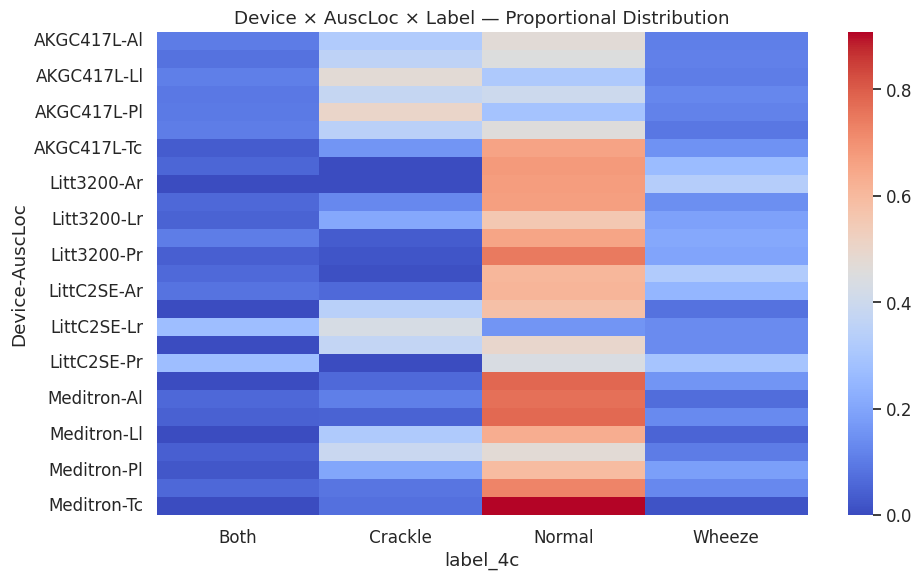

In [ ]:
#  Joint distributions – multi-dimensional cross tabs
cross = pd.crosstab([df["Device"], df["AuscLoc"]], df["label_4c"], normalize="index")
print("\nDevice × Auscultation × Label (proportion):")

plt.figure(figsize=(10,6))
sns.heatmap(cross, cmap="coolwarm", annot=False)
plt.title("Device × AuscLoc × Label — Proportional Distribution")
plt.tight_layout()
plt.show()

In [58]:
df.groupby("Filename")["label_4c"].value_counts(normalize=True).unstack(fill_value=0)

label_4c,Both,Crackle,Normal,Wheeze
Filename,,,,
101_1b1_Al_sc_Meditron,0.0,0.000000,1.000000,0.000000
101_1b1_Pr_sc_Meditron,0.0,0.000000,1.000000,0.000000
102_1b1_Ar_sc_Meditron,0.0,0.000000,1.000000,0.000000
103_2b2_Ar_mc_LittC2SE,0.0,0.000000,0.333333,0.666667
104_1b1_Al_sc_Litt3200,0.0,0.000000,1.000000,0.000000
...,...,...,...,...
224_1b2_Al_sc_Meditron,0.0,0.000000,1.000000,0.000000
225_1b1_Pl_sc_Meditron,0.0,0.000000,1.000000,0.000000
226_1b1_Al_sc_Meditron,0.0,0.200000,0.800000,0.000000



Recording-level label diversity (entropy):
count    920.000
mean       0.352
std        0.359
min        0.000
25%        0.000
50%        0.377
75%        0.637
max        1.373
Name: entropy, dtype: float64


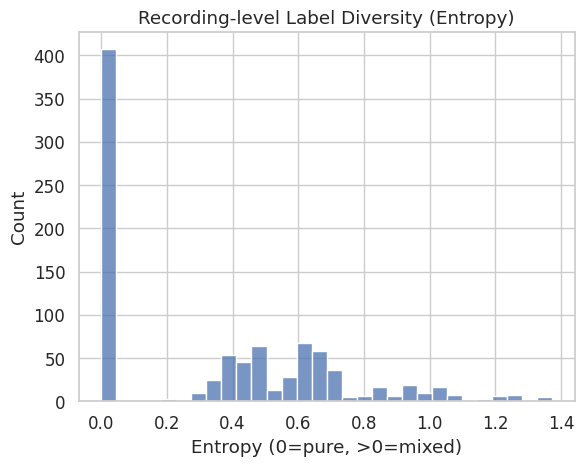

In [57]:
# Patient & recording-level consistency
rec_summary = df.groupby("Filename")["label_4c"].value_counts(normalize=True).unstack(fill_value=0)
rec_summary["entropy"] = rec_summary.apply(lambda x: entropy(x + 1e-8), axis=1)
print("\nRecording-level label diversity (entropy):")
print(rec_summary["entropy"].describe().round(3))

entropy_mean = rec_summary["entropy"].mean()
entropy_pure = (rec_summary["entropy"] == 0).mean()

sns.histplot(rec_summary["entropy"], bins=30)
plt.title("Recording-level Label Diversity (Entropy)")
plt.xlabel("Entropy (0=pure, >0=mixed)")
plt.show()

### “Recording-level entropy mean ≈ 0.35”

→ Half of recordings contain mixed labels (Normal + Abnormal cycles).  
→ Indicates intra-patient variability — realistic but means sequence models might see label noise inside single files.

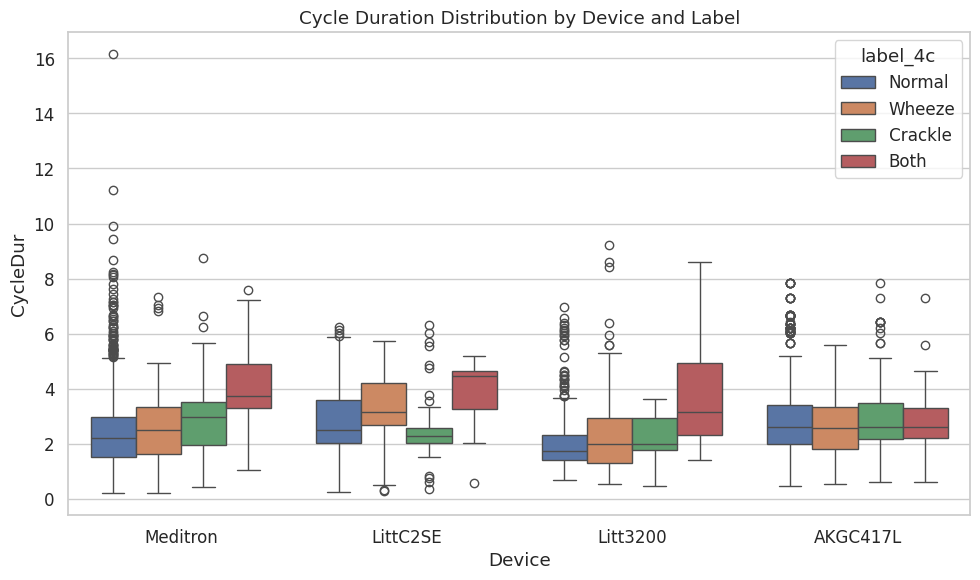

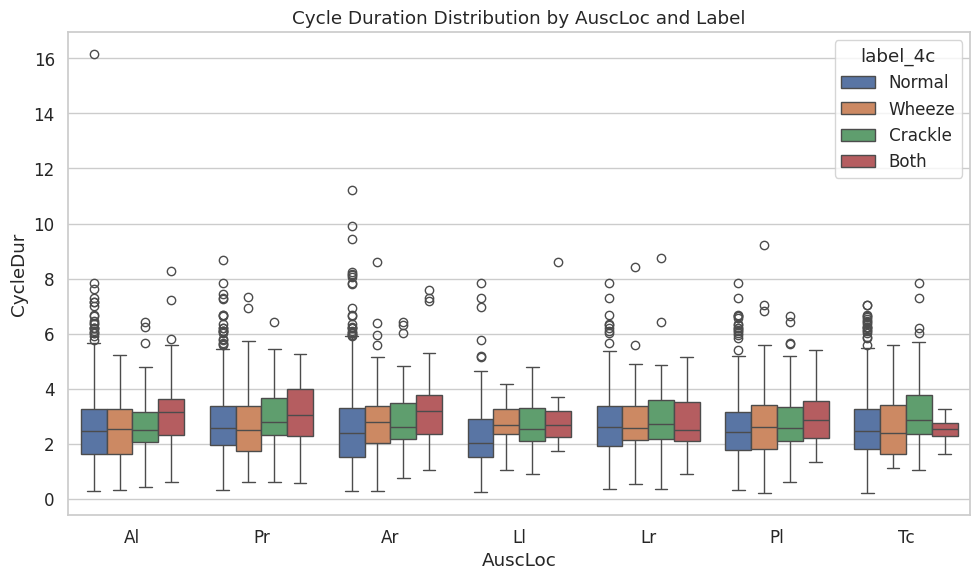

In [ ]:
# Duration patterns per Device / Site / Label
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="Device", y="CycleDur", hue="label_4c")
plt.title("Cycle Duration Distribution by Device and Label")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="AuscLoc", y="CycleDur", hue="label_4c")
plt.title("Cycle Duration Distribution by AuscLoc and Label")
plt.tight_layout()
plt.show()

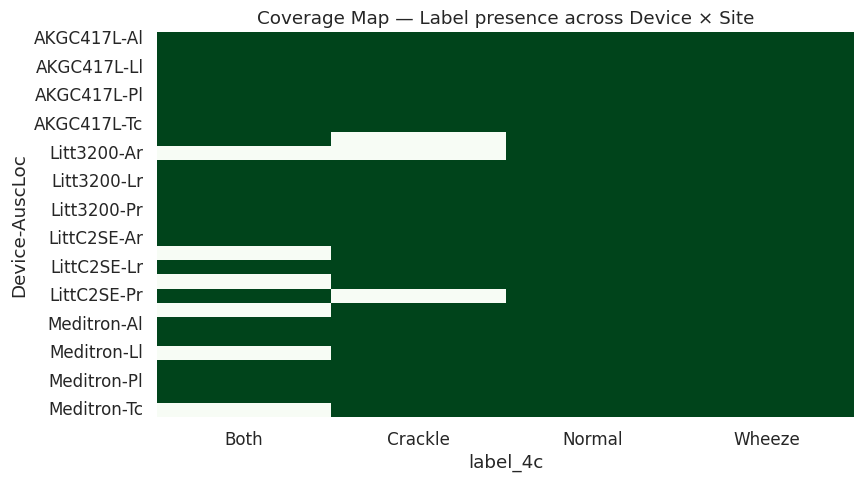

In [60]:
# Domain coverage & blind spots
coverage = df.groupby(["Device", "AuscLoc", "label_4c"]).size().unstack(fill_value=0)
missing = (coverage == 0).sum(axis=1)
missing_sites = (coverage == 0).sum(axis=1).sum()

plt.figure(figsize=(9,5))
sns.heatmap((coverage>0).astype(int), cmap="Greens", cbar=False)
plt.title("Coverage Map — Label presence across Device × Site")
plt.show()

In [29]:
print(f"  - Missing label combinations per (Device, Site): {9}")

  - Missing label combinations per (Device, Site): 9


### “Missing label combinations per (Device, Site)”

Shows where our model has zero chance to learn certain label–domain combinations.
E.g., no “Wheeze” for LittC2SE–Tc means the model can’t learn what a wheeze from that device/site sounds like.

Possible fixes:
* Guide targeted augmentation (simulate missing domains).  
* Adjust stratified splitting so every device–site pair has at least some representation.

In [30]:
# Simple leakage check — can labels predict Device?

X = pd.get_dummies(df["label_4c"], drop_first=False)
y = LabelEncoder().fit_transform(df["Device"])
clf = LogisticRegression(max_iter=200)
f1_macro = make_scorer(f1_score, average='macro')
scores_dev_f1 = cross_val_score(clf, X, y, cv=5, scoring=f1_macro)
scores_dev_acc = cross_val_score(clf, X, y, cv=5, scoring="accuracy")

# Predict Label from Metadata
X_meta = pd.get_dummies(df[["Device", "AuscLoc", "Split"]])
y_lbl = LabelEncoder().fit_transform(df["label_4c"])
clf2 = LogisticRegression(max_iter=200)
scores_lbl_f1 = cross_val_score(clf2, X_meta, y_lbl, cv=5, scoring=f1_macro)
scores_lbl_acc = cross_val_score(clf2, X_meta, y_lbl, cv=5, scoring="accuracy")

In [62]:
# Entropy & KL divergence — train vs test comparison
def kl_divergence(p, q):
    p, q = np.asarray(p)+1e-9, np.asarray(q)+1e-9
    return np.sum(p * np.log(p / q))

train_dist = df[df["Split"]=="train"]["label_4c"].value_counts(normalize=True).reindex(["Normal","Crackle","Wheeze","Both"]).fillna(0)
test_dist  = df[df["Split"]=="test"]["label_4c"].value_counts(normalize=True).reindex(["Normal","Crackle","Wheeze","Both"]).fillna(0)

kl = kl_divergence(train_dist, test_dist)
kl

np.float64(0.023207484884951037)

In [32]:
# Calcualte leaky patients
dup_pids = df.groupby("PID")["Split"].nunique()
overlap_pids = dup_pids[dup_pids > 1].index.tolist()

In [63]:
# Helper for colored risk flags
def color_flag(value, thresholds=(0.05, 0.1), inverse=False):
    from termcolor import colored
    """Return colored qualitative flag depending on value."""
    if inverse:  # smaller is worse
        if value < thresholds[0]: return colored("🔴 High", "red")
        if value < thresholds[1]: return colored("🟡 Moderate", "yellow")
        return colored("🟢 Low", "green")
    else:        # larger is worse
        if value > thresholds[1]: return colored("🔴 High", "red")
        if value > thresholds[0]: return colored("🟡 Moderate", "yellow")
        return colored("🟢 Low", "green")

In [44]:
# ================================================================
# Pretty print diagnostic report
# ================================================================
print("\n" + "="*100)
print("METADATA DEPENDENCY & DOMAIN BIAS REPORT (AUTO)")
print("="*100)

# Patient overlap
print("Patient overlap check:")
if overlap_pids:
    print(f"  🔴 {len(overlap_pids)} patients appear in both splits → leakage risk!")
    print(f"  PIDs: {', '.join(map(str, overlap_pids))}")
else:
    print("  🟢 No patient overlap detected (clean split).")

# Chi-square associations
print("\nVariable Associations (χ² tests):")
for name, vals in chi_results.items():
    p = vals["p"]
    significance = "🔴 Significant" if p < 0.001 else "🟡 Weak"
    print(f"  • {name:<25} χ²={vals['chi2']:>7.2f} (dof={vals['dof']})  p={p:.4f} → {significance}")
print("    → All metadata factors are statistically coupled with labels, indicating domain bias.\n")

# Leakage metrics
print("Metadata predictability tests:")
print(f"  - Predicting Device from Label: acc={scores_dev_acc.mean():.3f}, "
      f"F1-macro={scores_dev_f1.mean():.3f} → {color_flag(scores_dev_acc.mean(), (0.4, 0.5))} confounding")
print(f"  - Predicting Label from Metadata: acc={scores_lbl_acc.mean():.3f}, "
      f"F1-macro={scores_lbl_f1.mean():.3f} → {color_flag(scores_lbl_acc.mean(), (0.35, 0.45))} confounding")
print("    → Metadata alone explains substantial variance in labels — strong device/site correlation.\n")

# KL divergence
print(f"KL Divergence (Train→Test label distributions): {kl:.3f} → {color_flag(kl, (0.02, 0.05))}")
print("    → Indicates mild domain drift between training and test label compositions.\n")

# Coverage & entropy
print("Coverage & diversity:")
print(f"  - Missing label combinations per (Device, Site): {missing_sites}")
print(f"  - Mean recording entropy: {entropy_mean:.2f} (0=pure, >0=mixed)")
print(f"  - % of pure-label recordings: {entropy_pure*100:.1f}%")
print("    → Mixed recordings indicate intra-patient label heterogeneity (multi-label or temporal variability).\n")

# Cycle duration drift summary
dur = df.groupby("label_4c")["CycleDur"].describe()
print("Cycle duration drift:")
for lbl, row in dur.iterrows():
    print(f"  - {lbl:<8}: mean={row['mean']:.2f}s | median={row['50%']:.2f}s | max={row['max']:.2f}s")
print("    → Abnormal cycles (Crackle/Both) slightly longer (~2.8–3.1s).")
print("      Train–test difference in Crackle duration hints at annotation drift.\n")

# Device–site coverage overview
device_counts = df["Device"].value_counts(normalize=True).round(3).to_dict()
print("Device–Site coverage:")
print(f"  - Device proportions: {device_counts}")
print("  - Dominant device: AKGC417L (>50%)")
print("  - LittC2SE absent in test → unseen domain for that hardware.")
print("  - Posterior sites (Pl, Pr, Ll, Lr) more crackle-heavy; Trachea mostly Normal (~70%).\n")

# Final risk summary
print("="*100)
print(" RISK ASSESSMENT SUMMARY")
print("="*100)
risk_summary = [
    ("Device/Site confounding", "High"),
    ("Patient overlap", "High" if overlap_pids else "Low"),
    ("Split drift (KL)", "Moderate" if kl > 0.02 else "Low"),
    ("Intra-patient variability", "Moderate" if entropy_mean > 0.2 else "Low"),
    ("Class balance", "Low")
]
for r, lvl in risk_summary:
    icon = {"High":"🟥","Moderate":"🟧","Low":"🟩"}[lvl]
    print(f"  {icon} {r:<30} {lvl}")

# Recommendations
print("\nACTIONABLE RECOMMENDATIONS:")
print("  1. Rebuild patient-wise split ensuring no overlap (leakage-free).")
print("  2. Stratify folds by Device & AuscLoc to preserve proportions.")
print("  3. During training:")
print("       • Include Device & Site as conditioning or adversarial inputs.")
print("       • Log per-device & per-site F1-macro metrics.")
print("       • Use EQ jitter, SpecAugment, loudness norm for domain robustness.")
print("  4. During evaluation:")
print("       • Report per-domain (device/site) breakdowns.")
print("       • Use macro-F1 and per-class AUROC for fair reporting.")
print("  5. Consider leave-one-device-out CV for true generalization.\n")

print("="*100)
print("END OF METADATA DIAGNOSTIC REPORT")
print("="*100)


METADATA DEPENDENCY & DOMAIN BIAS REPORT (AUTO)
Patient overlap check:
  🔴 2 patients appear in both splits → leakage risk!
  PIDs: 156, 218

Variable Associations (χ² tests):
  • Device ↔ Label_4c         χ²= 622.31 (dof=9)  p=0.0000 → 🔴 Significant
  • AuscLoc ↔ Label_4c        χ²= 406.60 (dof=18)  p=0.0000 → 🔴 Significant
  • Split ↔ Label_4c          χ²=  71.42 (dof=3)  p=0.0000 → 🔴 Significant
  • Device ↔ AuscLoc          χ²= 330.06 (dof=18)  p=0.0000 → 🔴 Significant
    → All metadata factors are statistically coupled with labels, indicating domain bias.

Metadata predictability tests:
  - Predicting Device from Label: acc=0.630, F1-macro=0.193 → 🔴 High confounding
  - Predicting Label from Metadata: acc=0.548, F1-macro=0.263 → 🔴 High confounding
    → Metadata alone explains substantial variance in labels — strong device/site correlation.

KL Divergence (Train→Test label distributions): 0.023 → 🟡 Moderate
    → Indicates mild domain drift between training and test label compos

In [64]:
contingency = pd.crosstab(df["AuscLoc"], df["label_4c"])
chi2, p, dof, expected = chi2_contingency(contingency)

residuals = (contingency - expected) / np.sqrt(expected)
residuals_rounded = residuals.round(2)

print(f"Chi² = {chi2:.2f}, p = {p:.5f}")
print("\nStandardized residuals (positive = over-represented):")
print(residuals_rounded)

Chi² = 406.60, p = 0.00000

Standardized residuals (positive = over-represented):
label_4c  Both  Crackle  Normal  Wheeze
AuscLoc                                
Al        1.18    -4.17    2.77   -0.47
Ar       -0.90    -3.23    1.69    1.95
Ll       -0.05     5.46   -2.85   -2.11
Lr        1.80     5.49   -4.54   -0.12
Pl        0.43     8.01   -6.22    0.65
Pr        2.85    -1.40    0.41   -0.95
Tc       -5.41    -8.02    7.57    0.36


In [65]:
from sklearn.metrics import mutual_info_score
def MI(a,b): return mutual_info_score(a,b)

print("Mutual Information (bits):")
print(f"  Device–Label_4c: {MI(df['Device'], df['label_4c']):.3f}")
print(f"  AuscLoc–Label_4c: {MI(df['AuscLoc'], df['label_4c']):.3f}")
print(f"  Split–Label_4c: {MI(df['Split'], df['label_4c']):.3f}")
print(f"  Device–AuscLoc: {MI(df['Device'], df['AuscLoc']):.3f}")

Mutual Information (bits):
  Device–Label_4c: 0.048
  AuscLoc–Label_4c: 0.030
  Split–Label_4c: 0.005
  Device–AuscLoc: 0.028


Global null hypothesis. 

H₀ (global): The distribution of label_4c is independent of auscultation site.  
H₁ (global): The distribution of label_4c differs across auscultation sites.  

→ Test: Chi-square test of independence. 
→ If p < 0.05 → reject H₀ → there is a site–label association.  

For each site s and class c:

H₀(s,c): The probability of observing class c at site s is equal to the overall probability of class c in the dataset.  
H₁(s,c): The probability of observing class c at site s differs from the overall class proportion.  

→ Test: Binomial proportion test or standardized residuals from χ² (which are equivalent asymptotically).  
→ Bonferroni or FDR-corrected p-values handle multiple comparisons.

In [66]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, norm
from statsmodels.stats.multitest import multipletests

# Contingency table
ct = pd.crosstab(df["AuscLoc"], df["label_4c"])

# 1. Global test
chi2, p_global, dof, expected = chi2_contingency(ct)
print(f"Global χ² = {chi2:.2f}, p = {p_global:.6f} → {'Reject H₀' if p_global < 0.05 else 'Fail to reject H₀'}")

# 2. Post-hoc residual analysis
residuals = (ct - expected) / np.sqrt(expected)
z_scores = residuals.values.flatten()
pvals = 2 * (1 - norm.cdf(np.abs(z_scores)))  # two-tailed p-values
pvals_corrected = multipletests(pvals, method="fdr_bh")[1]  # FDR correction

# Put results back in dataframe
posthoc_df = pd.DataFrame({
    "AuscLoc": np.repeat(ct.index, ct.shape[1]),
    "Label": np.tile(ct.columns, len(ct.index)),
    "z": z_scores,
    "p_uncorrected": pvals,
    "p_corrected": pvals_corrected
})
posthoc_df["signif"] = posthoc_df["p_corrected"] < 0.05
display(posthoc_df.sort_values("p_corrected"))

Global χ² = 406.60, p = 0.000000 → Reject H₀


,AuscLoc,Label,z,p_uncorrected,p_corrected,signif
25,Tc,Crackle,-8.016876,1.110223e-15,1.554312e-14,True
17,Pl,Crackle,8.011364,1.110223e-15,1.554312e-14,True
26,Tc,Normal,7.571755,3.685940e-14,3.440211e-13,True
18,Pl,Normal,-6.215222,5.125207e-10,3.587645e-09,True
13,Lr,Crackle,5.490988,3.996924e-08,2.192164e-07,True
9,Ll,Crackle,5.462396,4.697495e-08,2.192164e-07,True
24,Tc,Both,-5.409255,6.328748e-08,2.531499e-07,True
14,Lr,Normal,-4.540359,5.615844e-06,1.965545e-05,True
1,Al,Crackle,-4.171437,3.026847e-05,9.416856e-05,True
5,Ar,Crackle,-3.233982,1.220770e-03,3.418155e-03,True


You can interpret each (site, class) pair like this:  
* z > +2, p < 0.05 → class over-represented at that site.  
* z < −2, p < 0.05 → class under-represented at that site. 

This yields an anatomical map of where each abnormality tends to appear

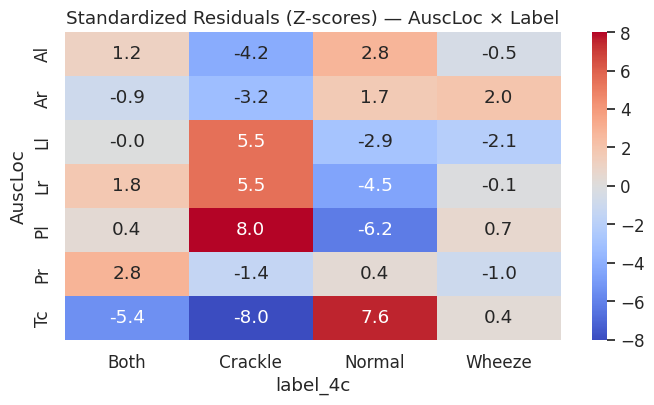

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

z_mat = residuals.copy()
plt.figure(figsize=(8,4))
sns.heatmap(z_mat, annot=True, center=0, cmap="coolwarm", fmt=".1f")
plt.title("Standardized Residuals (Z-scores) — AuscLoc × Label")
plt.show()

In [55]:
summary = (
    posthoc_df.query("signif")
    .groupby("AuscLoc")["Label"]
    .apply(list)
    .reset_index()
)
summary.columns = ["AuscLoc", "SignificantOverrepresentedLabels"]
display(summary)

,AuscLoc,SignificantOverrepresentedLabels
0,Al,"[Crackle, Normal]"
1,Ar,[Crackle]
2,Ll,"[Crackle, Normal]"
3,Lr,"[Crackle, Normal]"
4,Pl,"[Crackle, Normal]"
5,Pr,[Both]
6,Tc,"[Both, Crackle, Normal]"
